In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
# import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
#
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
df = pd.read_csv('ElectricCarData_Clean.csv')

In [ ]:
df = df.replace('-','', regex=True)
df['FastCharge_KmH'] = df['FastCharge_KmH'].replace('',0, regex=True)
df['FastCharge_KmH'] = df['FastCharge_KmH'].replace(' ',0, regex=True)
df.head(5)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,Price
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997


In [ ]:
features = ['AccelSec','TopSpeed_KmH','Range_Km','Price','FastCharge_KmH','RapidCharge','BodyStyle']

## Transform data

In [ ]:
datast = make_column_transformer(
    (StandardScaler(), ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Price', 'FastCharge_KmH']),
    (OneHotEncoder(handle_unknown = 'ignore'), ['RapidCharge', 'BodyStyle']),
    remainder='drop'
)

X = df[features]
y = df['Efficiency_WhKm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear Predict

### evaluate

In [ ]:
pipeline_Linear = make_pipeline(
    datast,
    LinearRegression()
)


In [ ]:
test = cross_validate(
    pipeline_Linear,
    X_test,
    y_test,
    scoring = ('neg_root_mean_squared_error','neg_mean_absolute_error'),
    cv=5,
)


In [ ]:
maelr4 = -np.mean(test['test_neg_mean_absolute_error'])
rmselr4 = -np.mean(test['test_neg_root_mean_squared_error'])
print(f"Linearnew  - MAE: {maelr4}, RMSE: {rmselr4}")

Linearnew  - MAE: 19.55180087257738, RMSE: 24.99235174605656


### predict

In [ ]:
pipeline_Linear.fit(df[features],df['Efficiency_WhKm'])
predict = pipeline_Linear.predict(
    X=X_test
)
pipeline_Linear.score(X_test,y_test)

0.759201393379708

## KNN predict

In [ ]:
datast = make_column_transformer(
    (StandardScaler(), ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Price', 'FastCharge_KmH']),
    (OneHotEncoder(handle_unknown = 'ignore'), ['RapidCharge', 'BodyStyle']),
    remainder='drop'
)
pipelineKNN = make_pipeline(
    datast,
    KNeighborsRegressor()
)

In [ ]:
param_grid = {
    'kneighborsregressor__n_neighbors': range(1, 45),
    'kneighborsregressor__metric': [ 'euclidean', 'manhattan'],
}


In [ ]:
grid_search = GridSearchCV(
    pipelineKNN,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train,y_train)
bestestimator = grid_search.best_estimator_

In [ ]:
val = bestestimator.predict(X_test)

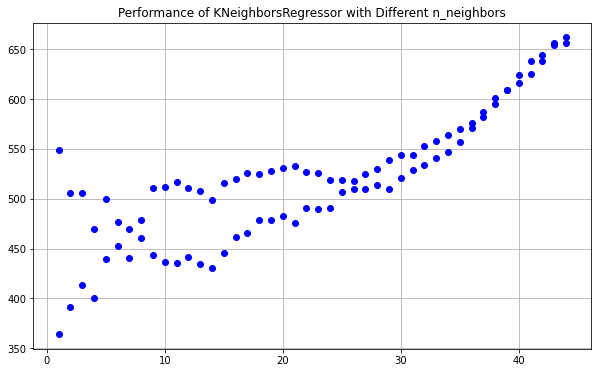

In [ ]:
results = grid_search.cv_results_
params = results['params']
n_neighbors = [param['kneighborsregressor__n_neighbors'] for param in params]
mean_mae = -results['mean_test_score']  # Convert from negative MAE to positive MAE
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors, mean_mae, marker='o', linestyle='', color='b')
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Mean Absolute Error')
plt.grid(True)

plt.title('Performance of KNeighborsRegressor with Different n_neighbors')
plt.savefig('test.png')

In [ ]:
def evaluate_model(model, X, Y):
    predictions = model.predict(X)
    mae = mean_absolute_error(Y, predictions)
    rmse = np.sqrt(mean_squared_error(Y, predictions))
    return mae,rmse

knn_mae_new,knn_rmse_new =  evaluate_model(bestestimator, X_test, y_test)
knn_mae,knn_rms = evaluate_model(pipeline_Linear, X_test, y_test)
print(f"KNN      - MAE: {knn_mae_new},          RMSE: {knn_rmse_new}")
print(f"linear      - MAE: {knn_mae},          RMSE: {knn_rms}")
grid_search.best_score_

KNN      - MAE: 17.580645161290324,          RMSE: 29.36917409626587
linear      - MAE: 12.22849533442446,          RMSE: 16.440309671728016


-364.352380952381

## Correlation

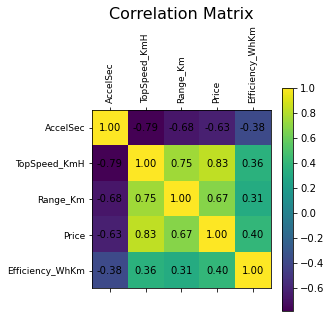

In [ ]:
featurecorr = ['AccelSec','TopSpeed_KmH','Range_Km','Price','Efficiency_WhKm']
df[featurecorr].corr()
plt.matshow(df[featurecorr].corr())
plt.xticks(range(len(featurecorr)),featurecorr, fontsize=9, rotation=90)
plt.yticks(range(len(featurecorr)),featurecorr, fontsize=9)
cb = plt.colorbar()

for (i, j), z in np.ndenumerate(df[featurecorr].corr()):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.title('Correlation Matrix', fontsize=16)
plt.savefig('corrmatrix.png', bbox_inches='tight')

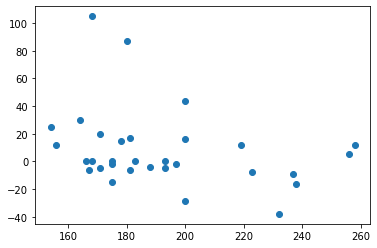

In [ ]:
plt.scatter(bestestimator.predict(X_test),y_test-bestestimator.predict(X_test),label="KNN")


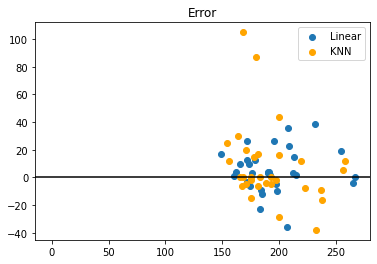

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(predict,y_test-predict,label="Linear")
plt.scatter(bestestimator.predict(X_test),y_test-bestestimator.predict(X_test),label="KNN", c='orange')

plt.axline((-1,0),(1,0),c='black')
plt.title('Error')
plt.legend()
# plt.xlabel('residual')

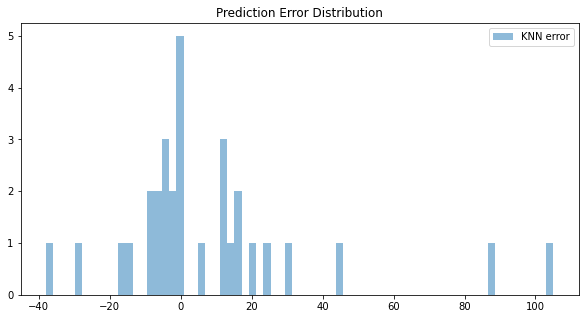

In [ ]:
plt.figure(figsize=(10, 5))
# plt.hist(y_test - predict,label='Linear error',alpha=0.5,bins=70,)
plt.hist(y_test - val,label='KNN error',alpha=0.5,bins=70,)

plt.title('Prediction Error Distribution')
# plt.xlabel('Error')
# plt.ylabel("Number")
plt.legend()